<a href="https://colab.research.google.com/github/jkf87/rdf-agent-workflow-tutorial/blob/main/rdf_vector_llm_kosbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RDF + Ko-SBERT + LLM 연동 예제

**임베딩 모델:** `jhgan/ko-sroberta-multitask` (한국어 특화 Sentence-BERT)

**장점:**
- 한국어 의미 유사도에 최적화
- 로컬 실행 (API 호출 불필요, 무료)
- 빠른 추론 속도

```
쿼리 → Ko-SBERT 임베딩 → FAISS 검색 → URI → SPARQL 조회 → Gemini LLM 선택
```

## 1. 환경 설정

In [1]:
# 필요한 패키지 설치해줘.
# rdflib은 RDF 그래프 다루는 거,
# faiss-cpu는 벡터 검색하는 거,
# sentence-transformers는 Ko-SBERT 쓰려고,
# google-genai는 Gemini LLM 호출하려고.
!pip install rdflib faiss-cpu sentence-transformers google-genai numpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 37.9 MB/s eta 0:00:00


In [2]:
# 기본 라이브러리 불러와.
# os는 파일 경로 다루려고,
# numpy는 벡터 연산하려고,
# List, Dict는 타입 힌트용이야.
import os
import numpy as np
from typing import List, Dict

# API 키 설정해줘.
# 임베딩은 로컬 Ko-SBERT 쓰니까 키 필요 없어.
# Gemini LLM 호출할 때만 키 필요해.
os.environ["GOOGLE_API_KEY"] = ""  # <- Gemini LLM용

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

## 2. RDF 온톨로지 로드

In [3]:
# rdflib에서 필요한 것들 가져와.
# Graph는 RDF 그래프 담는 그릇이고,
# Namespace는 URI 접두사 정의하려고,
# RDF, RDFS는 표준 온톨로지 접두사야.
from rdflib import Graph, Namespace, RDF, RDFS

# 우리 온톨로지 네임스페이스 정의해.
# mas는 multi-agent-system의 약자야.
MAS = Namespace("http://example.org/multi-agent-system#")

# 빈 그래프 만들어.
graph = Graph()

# 온톨로지 파일 경로 지정해.
ontology_path = "../ontology/workflow_ontology.ttl"

# 파일 있으면 로드하고, 없으면 샘플 만들어.
if os.path.exists(ontology_path):
    # turtle 형식으로 파싱해.
    graph.parse(ontology_path, format="turtle")
    print(f"온톨로지 로드: {len(graph)} triples")
else:
    # 샘플 온톨로지 직접 정의해.
    # 워크플로우 4개 만들어볼게.
    sample_ttl = """
    @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
    @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
    @prefix mas: <http://example.org/multi-agent-system#> .

    mas:ResearchTask a mas:SequentialWorkflow ;
        rdfs:label "AI 트렌드 조사"@ko ;
        mas:keywords "AI, 인공지능, 트렌드, 조사, 연구, 분석, 최신" ;
        mas:useCases "기술 동향 파악, 시장 조사" ;
        mas:hasAgent mas:ResearchAgent, mas:WriterAgent .

    mas:CodeReviewTask a mas:ParallelWorkflow ;
        rdfs:label "코드 리뷰"@ko ;
        mas:keywords "코드, 리뷰, 검토, 분석, 버그, 품질, 개발" ;
        mas:useCases "코드 품질 검사, 버그 탐지" ;
        mas:hasAgent mas:CoderAgent, mas:ReviewerAgent .

    mas:DebateTask a mas:DebateWorkflow ;
        rdfs:label "찬반 토론"@ko ;
        mas:keywords "토론, 찬반, 논쟁, 비교, 장단점, 논의" ;
        mas:useCases "복잡한 의사결정, 다각도 분석" ;
        mas:hasAgent mas:DebateAgent .

    mas:ConsensusTask a mas:ConsensusWorkflow ;
        rdfs:label "합의 도출"@ko ;
        mas:keywords "합의, 투표, 결정, 종합, 전문가, 의견" ;
        mas:useCases "고위험 결정, 전문가 의견 종합" ;
        mas:hasAgent mas:ConsensusAgent .
    """
    graph.parse(data=sample_ttl, format="turtle")
    print(f"샘플 온톨로지 생성: {len(graph)} triples")

샘플 온톨로지 생성: 22 triples


In [4]:
# SPARQL로 워크플로우 조회해볼게.
query = """
PREFIX mas: <http://example.org/multi-agent-system#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?workflow ?label ?keywords ?useCases
WHERE {
    ?workflow mas:keywords ?keywords .
    OPTIONAL { ?workflow rdfs:label ?label }
    OPTIONAL { ?workflow mas:useCases ?useCases }
}
"""
# mas는 http://example.org/multi-agent-system#로 선언할게,
# rdfs는 http://www.w3.org/2000/01/rdf-schema#로 선언할게.

# workflow 찾아, label 찾아, keywords 찾아, useCases 찾아.

# workflow의 keywords 속성 있어야 해.
# 있으면 가져오는 거: label 있으면 가져와, useCases 있으면 가져와.

# 쿼리 실행해.
results = graph.query(query)

# 결과를 리스트로 변환해.
# 각 row에서 uri, label, keywords, useCases 뽑아서 딕셔너리로 만들어.
workflows = []
for row in results:
    workflows.append({
        "uri": str(row.workflow),
        "label": str(row.label) if row.label else "",
        "keywords": str(row.keywords) if row.keywords else "",
        "useCases": str(row.useCases) if row.useCases else "",
    })

# 결과 출력해봐.
print(f"워크플로우: {len(workflows)}개")
for wf in workflows:
    print(f"  - {wf['label']}")

워크플로우: 4개
  - AI 트렌드 조사
  - 코드 리뷰
  - 찬반 토론
  - 합의 도출


## 2.1 온톨로지 시각화

워크플로우 패턴과 에이전트 관계를 NetworkX로 시각화

/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28005296.py:93: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-inp

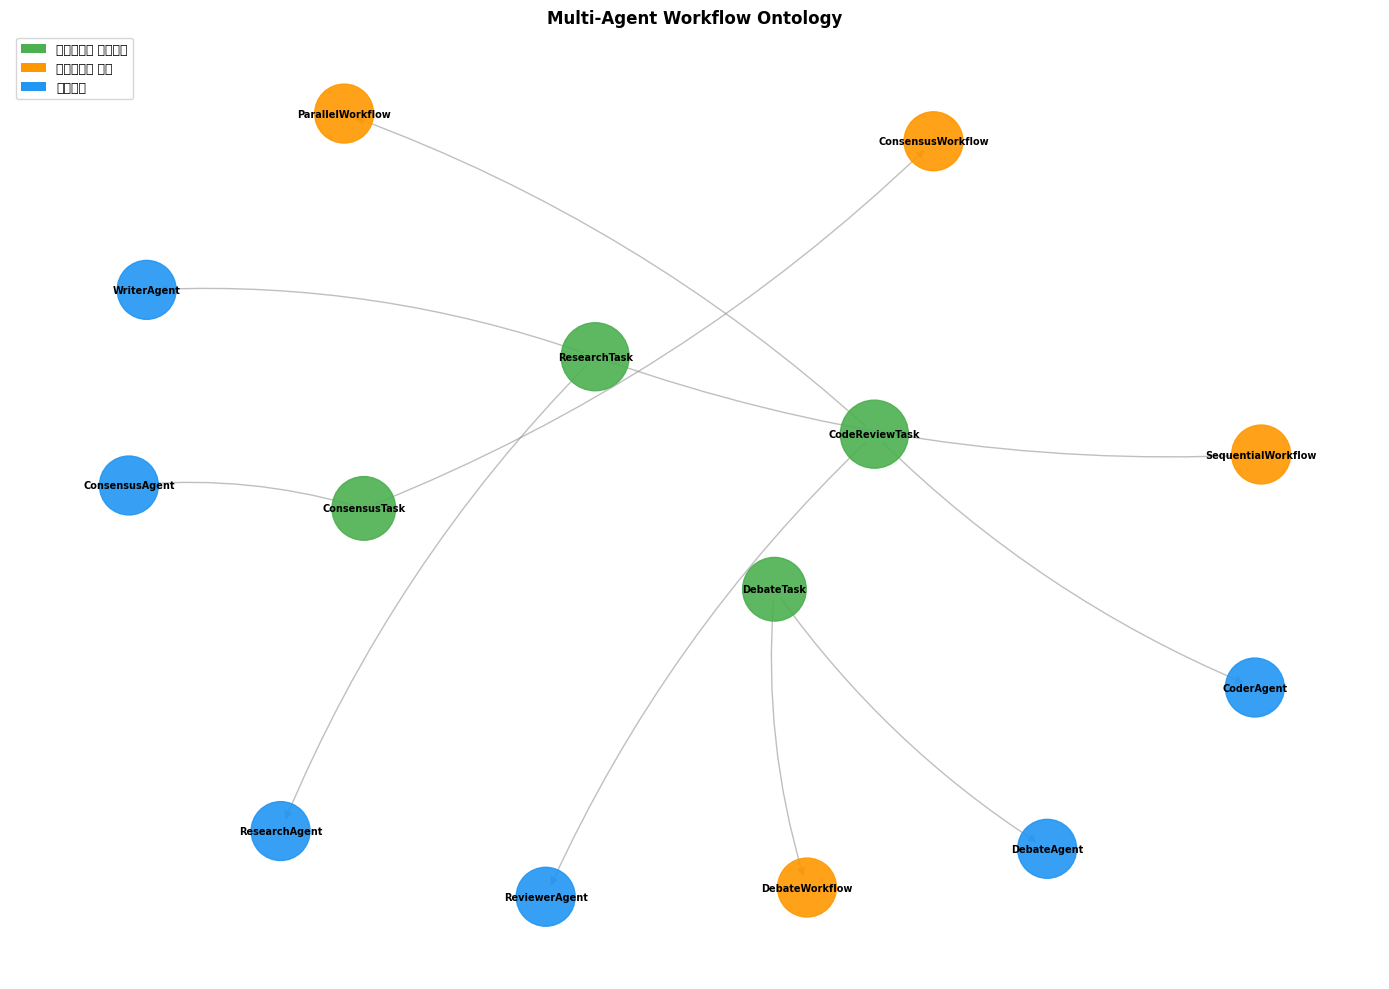

노드: 14개 | 엣지: 10개


In [5]:
# 시각화 라이브러리 가져와.
# networkx는 그래프 구조 만들려고,
# matplotlib는 그림 그리려고,
# platform은 OS 확인해서 폰트 설정하려고.
import networkx as nx
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정해줘.
# macOS면 AppleGothic,
# Windows면 Malgun Gothic,
# Linux면 NanumGothic 써.
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        pass  # 폰트 없으면 기본 폰트 써
plt.rcParams['axes.unicode_minus'] = False

def visualize_ontology(rdf_graph):
    """RDF 온톨로지 시각화해주는 함수야."""
    # NetworkX 방향 그래프 만들어.
    G = nx.DiGraph()

    # 색상 정의해.
    # workflow는 녹색, agent는 파랑, pattern은 주황.
    colors = {
        'workflow': '#4CAF50',
        'agent': '#2196F3',
        'pattern': '#FF9800',
    }
    node_colors = {}

    MAS_NS = Namespace("http://example.org/multi-agent-system#")

    # keywords 있는 주어들 돌면서 노드 추가해.
    # 워크플로우 인스턴스들이야.
    for s in rdf_graph.subjects(MAS_NS.keywords, None):
        name = str(s).split('#')[-1]
        G.add_node(name)
        node_colors[name] = colors['workflow']

        # 워크플로우 타입 찾아서 연결해.
        for t in rdf_graph.objects(s, RDF.type):
            type_name = str(t).split('#')[-1]
            if 'Workflow' in type_name and type_name != 'WorkflowPattern':
                G.add_node(type_name)
                node_colors[type_name] = colors['pattern']
                G.add_edge(name, type_name, relation='type')

        # 에이전트 찾아서 연결해.
        for agent in rdf_graph.objects(s, MAS_NS.hasAgent):
            agent_name = str(agent).split('#')[-1]
            G.add_node(agent_name)
            node_colors[agent_name] = colors['agent']
            G.add_edge(name, agent_name, relation='hasAgent')

    # 그림 그려.
    fig, ax = plt.subplots(figsize=(14, 10))

    # spring layout으로 배치해.
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    node_color_list = [node_colors.get(n, '#9E9E9E') for n in G.nodes()]

    # 노드 크기는 연결 수에 따라 조정해.
    node_sizes = [1500 + 300 * G.degree(n) for n in G.nodes()]

    # 노드 그려.
    nx.draw_networkx_nodes(G, pos, node_color=node_color_list,
                           node_size=node_sizes, alpha=0.9, ax=ax)
    # 레이블 그려.
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold', ax=ax)
    # 엣지 그려.
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True,
                           arrowsize=12, alpha=0.5, ax=ax,
                           connectionstyle="arc3,rad=0.1")

    # 범례 추가해.
    from matplotlib.patches import Patch
    legend_items = [
        Patch(facecolor=colors['workflow'], label='워크플로우 인스턴스'),
        Patch(facecolor=colors['pattern'], label='워크플로우 패턴'),
        Patch(facecolor=colors['agent'], label='에이전트'),
    ]
    ax.legend(handles=legend_items, loc='upper left', fontsize=9)

    ax.set_title("Multi-Agent Workflow Ontology", fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"노드: {G.number_of_nodes()}개 | 엣지: {G.number_of_edges()}개")
    return G

# 온톨로지 시각화해봐.
G = visualize_ontology(graph)

## 3. Ko-SBERT 임베딩 모델 로드

`jhgan/ko-sroberta-multitask`
- 한국어 특화 Sentence-BERT
- 768차원 임베딩
- 로컬 실행 (무료)

In [6]:
# sentence_transformers에서 SentenceTransformer 가져와.
# 이게 Ko-SBERT 모델 로드하는 클래스야.
from sentence_transformers import SentenceTransformer

# Ko-SBERT 모델 로드해.
# jhgan/ko-sroberta-multitask는 한국어 특화 모델이야.
# 허깅페이스에서 자동으로 다운로드 돼.
EMBEDDING_MODEL = "jhgan/ko-sroberta-multitask"
embedder = SentenceTransformer(EMBEDDING_MODEL)

# 임베딩 차원은 768이야.
# Ko-SBERT가 768차원 벡터 만들어줘.
EMBEDDING_DIM = 768

print(f"모델: {EMBEDDING_MODEL}")
print(f"차원: {EMBEDDING_DIM}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

모델: jhgan/ko-sroberta-multitask
차원: 768


In [7]:
def get_embedding(text: str) -> np.ndarray:
    """텍스트를 Ko-SBERT 임베딩으로 변환해주는 함수야."""
    # embedder.encode()로 텍스트를 벡터로 변환해.
    # convert_to_numpy=True 하면 numpy 배열로 반환해.
    # float32로 캐스팅하면 FAISS랑 호환 잘 돼.
    return embedder.encode(text, convert_to_numpy=True).astype(np.float32)


# 테스트해봐.
# "AI 트렌드 조사"를 임베딩으로 변환해보자.
test_emb = get_embedding("AI 트렌드 조사")
print(f"Shape: {test_emb.shape}")  # (768,) 나와야 해
print(f"Sample: {test_emb[:5]}")   # 처음 5개 값 확인해봐

Shape: (768,)
Sample: [ 0.05853108  0.27154315 -0.62911665 -0.36913878 -0.22479625]


## 4. 한국어 의미 유사도 테스트

Ko-SBERT가 한국어에서 얼마나 잘 작동하는지 확인

In [8]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """두 벡터의 코사인 유사도 계산해주는 함수야."""
    # 코사인 유사도 = (a · b) / (|a| * |b|)
    # a랑 b 내적하고, 각각 노름으로 나눠줘.
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


# 의미적으로 유사한 쌍 vs 다른 쌍 테스트해봐.
test_pairs = [
    # 유사한 쌍 (높은 점수 기대)
    ("AI 트렌드 조사", "인공지능 최신 동향 연구"),
    ("코드 리뷰", "소스코드 검토 분석"),
    ("찬반 토론", "장단점 비교 논쟁"),
    # 다른 쌍 (낮은 점수 기대)
    ("AI 트렌드 조사", "코드 리뷰"),
    ("찬반 토론", "합의 도출"),
]

print("Ko-SBERT 한국어 의미 유사도:")
print("=" * 60)
# 각 쌍에 대해 유사도 계산해봐.
for t1, t2 in test_pairs:
    sim = cosine_sim(get_embedding(t1), get_embedding(t2))
    bar = "█" * int(sim * 20)  # 막대 그래프로 시각화
    print(f"{sim:.3f} {bar}")
    print(f"  '{t1}' vs '{t2}'\n")

Ko-SBERT 한국어 의미 유사도:
0.772 ███████████████
  'AI 트렌드 조사' vs '인공지능 최신 동향 연구'

0.627 ████████████
  '코드 리뷰' vs '소스코드 검토 분석'

0.694 █████████████
  '찬반 토론' vs '장단점 비교 논쟁'

0.336 ██████
  'AI 트렌드 조사' vs '코드 리뷰'

0.372 ███████
  '찬반 토론' vs '합의 도출'



## 5. FAISS 벡터 인덱스 구축

### 벡터에 학습되는 문서 (Document)

FAISS 인덱스에는 **RDF 온톨로지에서 추출한 워크플로우 메타데이터**가 학습됩니다:

| 필드 | 출처 | 예시 |
|------|------|------|
| `label` | `rdfs:label` | "AI 트렌드 조사", "코드 리뷰" |
| `keywords` | `mas:keywords` | "AI, 인공지능, 트렌드, 조사, 연구" |
| `useCases` | `mas:useCases` | "기술 동향 파악, 시장 조사" |

**학습 문서 형태:**
```
"{label} {keywords} {useCases}"
```

**예시 문서:**
```
"AI 트렌드 조사 AI, 인공지능, 트렌드, 조사, 연구, 분석, 최신 기술 동향 파악, 시장 조사"
```

### 핵심 흐름: RDF → SPARQL → 텍스트 → 벡터

```
┌─────────────────────────────────────────────────────────────────┐
│  RDF 온톨로지 (.ttl 파일)                                        │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ mas:ResearchTask                                         │   │
│  │   rdfs:label "AI 트렌드 조사"                             │   │
│  │   mas:keywords "AI, 인공지능, 트렌드, 조사..."            │   │
│  │   mas:useCases "기술 동향 파악"                          │   │
│  │   mas:hasAgent mas:ResearchAgent, mas:WriterAgent        │   │
│  └─────────────────────────────────────────────────────────┘   │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼ SPARQL 쿼리
┌─────────────────────────────────────────────────────────────────┐
│  SELECT ?workflow ?label ?keywords ?useCases                    │
│  WHERE { ?workflow mas:keywords ?keywords . ... }               │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼ 텍스트 결합 (학습 문서)
┌─────────────────────────────────────────────────────────────────┐
│  "AI 트렌드 조사 AI, 인공지능, 트렌드, 조사... 기술 동향 파악"    │
│   └── label ──┘  └────── keywords ──────┘   └── useCases ──┘   │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼ Ko-SBERT 임베딩
┌─────────────────────────────────────────────────────────────────┐
│  [0.058, 0.271, -0.629, -0.369, ...] (768차원 벡터)             │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼ FAISS 인덱스 저장
┌─────────────────────────────────────────────────────────────────┐
│  Index 0: [벡터] → URI: mas:SimpleQA                            │
│  Index 1: [벡터] → URI: mas:CodeDev                             │
│  Index 2: [벡터] → URI: mas:ResearchTask                        │
│  ...                                                            │
└─────────────────────────────────────────────────────────────────┘
```

### 검색 시 흐름
```
사용자 쿼리 "AI 트렌드 알려줘"
       │
       ▼ Ko-SBERT 임베딩
   [쿼리 벡터 768차원]
       │
       ▼ FAISS 코사인 유사도 검색
   Top-K 인덱스 반환 (예: [2, 5, 11])
       │
       ▼ 메타데이터 조회
   URI 획득 → SPARQL로 상세 정보 조회
```

In [9]:
# faiss 가져와.
# FAISS는 Facebook에서 만든 벡터 검색 라이브러리야.
import faiss

# FAISS 인덱스 만들어.
# IndexFlatIP는 Inner Product (내적) 기반이야.
# 정규화된 벡터에서 내적 = 코사인 유사도야.
index = faiss.IndexFlatIP(EMBEDDING_DIM)

# 메타데이터 담을 리스트 만들어.
# FAISS는 벡터만 저장하니까 메타데이터는 따로 관리해야 해.
metadata_list: List[Dict] = []

print("워크플로우 임베딩 생성 (Ko-SBERT)...")

# 각 워크플로우마다 돌면서 임베딩 만들어.
for wf in workflows:
    # 검색용 텍스트 만들어.
    # label이랑 keywords랑 useCases 합쳐.
    text = f"{wf['label']} {wf['keywords']} {wf['useCases']}"

    # Ko-SBERT로 임베딩 만들어.
    emb = get_embedding(text)

    # L2 정규화해.
    # 정규화하면 내적이 코사인 유사도랑 같아져.
    faiss.normalize_L2(emb.reshape(1, -1))

    # 인덱스에 추가해.
    index.add(emb.reshape(1, -1))

    # 메타데이터도 추가해.
    metadata_list.append(wf)

    print(f"  + {wf['label']}")

print(f"\nFAISS 인덱스: {index.ntotal}개")

워크플로우 임베딩 생성 (Ko-SBERT)...
  + AI 트렌드 조사
  + 코드 리뷰
  + 찬반 토론
  + 합의 도출

FAISS 인덱스: 4개


### 5.1 FAISS 인덱스 저장/로드

인덱스를 파일로 저장하면 재시작 시 빠르게 로드할 수 있습니다.

**저장 파일:**
- `workflow_index.faiss`: FAISS 벡터 인덱스 (768차원 × N개)
- `workflow_metadata.json`: 메타데이터 (URI, label, keywords 등)

In [10]:
# json 가져와.
# 메타데이터 저장할 때 JSON 형식으로 저장할 거야.
import json

# 저장 경로 정의해.
INDEX_PATH = "workflow_index.faiss"      # FAISS 인덱스 파일
METADATA_PATH = "workflow_metadata.json"  # 메타데이터 JSON 파일


def save_index(idx, metadata, index_path=INDEX_PATH, metadata_path=METADATA_PATH):
    """FAISS 인덱스와 메타데이터 저장해주는 함수야."""
    # FAISS 인덱스 저장해.
    # faiss.write_index()로 바이너리 파일로 저장해.
    faiss.write_index(idx, index_path)

    # 메타데이터 JSON으로 저장해.
    # ensure_ascii=False 하면 한글 안 깨져.
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)

    print(f"저장 완료:")
    print(f"  - 인덱스: {index_path} ({idx.ntotal}개 벡터)")
    print(f"  - 메타데이터: {metadata_path}")


def load_index(index_path=INDEX_PATH, metadata_path=METADATA_PATH):
    """저장된 FAISS 인덱스와 메타데이터 로드해주는 함수야."""
    # 파일 있는지 확인해.
    if not os.path.exists(index_path) or not os.path.exists(metadata_path):
        raise FileNotFoundError(f"인덱스 파일 없음: {index_path}, {metadata_path}")

    # FAISS 인덱스 로드해.
    # faiss.read_index()로 바이너리 파일에서 읽어.
    idx = faiss.read_index(index_path)

    # 메타데이터 JSON에서 로드해.
    with open(metadata_path, "r", encoding="utf-8") as f:
        metadata = json.load(f)

    print(f"로드 완료:")
    print(f"  - 인덱스: {idx.ntotal}개 벡터")
    print(f"  - 메타데이터: {len(metadata)}개 항목")

    return idx, metadata


# 현재 인덱스 저장해봐.
save_index(index, metadata_list)

저장 완료:
  - 인덱스: workflow_index.faiss (4개 벡터)
  - 메타데이터: workflow_metadata.json


In [11]:
# 저장된 인덱스 로드 테스트해봐.
loaded_index, loaded_metadata = load_index()

# 로드된 인덱스로 검색 테스트해봐.
print("\n로드된 인덱스로 검색 테스트:")

# 쿼리 임베딩 만들어.
q_vec = get_embedding("AI 트렌드 조사")

# 정규화해.
faiss.normalize_L2(q_vec.reshape(1, -1))

# 검색해. top 3 가져와.
scores, indices = loaded_index.search(q_vec.reshape(1, -1), 3)

# 결과 출력해.
for score, idx in zip(scores[0], indices[0]):
    if idx >= 0:
        print(f"  - {loaded_metadata[idx]['label']} (score: {score:.4f})")

로드 완료:
  - 인덱스: 4개 벡터
  - 메타데이터: 4개 항목

로드된 인덱스로 검색 테스트:
  - AI 트렌드 조사 (score: 0.8896)
  - 코드 리뷰 (score: 0.3575)
  - 찬반 토론 (score: 0.2725)


## 6. 벡터 검색

In [12]:
def vector_search(query: str, top_k: int = 3) -> List[Dict]:
    """Ko-SBERT + FAISS 벡터 검색해주는 함수야."""
    # 쿼리를 임베딩으로 변환해.
    q_vec = get_embedding(query)

    # L2 정규화해.
    faiss.normalize_L2(q_vec.reshape(1, -1))

    # FAISS에서 검색해.
    # scores는 유사도 점수, indices는 인덱스 번호야.
    scores, indices = index.search(q_vec.reshape(1, -1), top_k)

    # 결과 리스트 만들어.
    results = []
    for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
        # 유효한 인덱스면 결과에 추가해.
        if idx >= 0:
            r = metadata_list[idx].copy()
            r["score"] = float(score)
            r["rank"] = i + 1
            results.append(r)
    return results

In [13]:
# 테스트 쿼리들 정의해.
test_queries = [
    "AI 최신 트렌드 알려줘",
    "이 코드 검토해줘",
    "장단점 비교해서 토론해줘",
    "전문가 의견 종합해줘",
]

print("Ko-SBERT 벡터 검색 결과:")
print("=" * 60)

# 각 쿼리마다 검색해봐.
for q in test_queries:
    print(f"\n쿼리: '{q}'")
    # top 2개 가져와.
    for r in vector_search(q, top_k=2):
        print(f"  [{r['rank']}] {r['label']} (score: {r['score']:.4f})")

Ko-SBERT 벡터 검색 결과:

쿼리: 'AI 최신 트렌드 알려줘'
  [1] AI 트렌드 조사 (score: 0.8071)
  [2] 코드 리뷰 (score: 0.3422)

쿼리: '이 코드 검토해줘'
  [1] 코드 리뷰 (score: 0.7287)
  [2] AI 트렌드 조사 (score: 0.2782)

쿼리: '장단점 비교해서 토론해줘'
  [1] 찬반 토론 (score: 0.6093)
  [2] 코드 리뷰 (score: 0.3942)

쿼리: '전문가 의견 종합해줘'
  [1] 합의 도출 (score: 0.6326)
  [2] 찬반 토론 (score: 0.5246)


## 7. SPARQL 상세 조회

In [14]:
def get_workflow_details(uri: str) -> Dict:
    """SPARQL로 워크플로우 상세 정보 조회해주는 함수야."""
    # SPARQL 쿼리 만들어.
    # uri 찾아, label 찾아, type 찾아, keywords 찾아, useCases 찾아, agent 찾아.
    q = f"""
    PREFIX mas: <http://example.org/multi-agent-system#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

    SELECT ?label ?type ?keywords ?useCases ?agent
    WHERE {{
        <{uri}> rdfs:label ?label .
        OPTIONAL {{ <{uri}> rdf:type ?type }}
        OPTIONAL {{ <{uri}> mas:keywords ?keywords }}
        OPTIONAL {{ <{uri}> mas:useCases ?useCases }}
        OPTIONAL {{ <{uri}> mas:hasAgent ?agent }}
    }}
    """
    # label 있어야 해.
    # 있으면 가져오는 거: type 있으면 가져와, keywords 있으면 가져와,
    # useCases 있으면 가져와, agent 있으면 가져와.

    # 결과 담을 딕셔너리 만들어.
    details = {"uri": uri, "label": "", "types": [], "agents": []}

    # 쿼리 실행하고 결과 파싱해.
    for row in graph.query(q):
        if row.label:
            details["label"] = str(row.label)
        if row.type:
            # URI에서 # 뒷부분만 추출해.
            t = str(row.type).split("#")[-1]
            if t not in details["types"]:
                details["types"].append(t)
        if row.agent:
            # URI에서 # 뒷부분만 추출해.
            a = str(row.agent).split("#")[-1]
            if a not in details["agents"]:
                details["agents"].append(a)

    return details

## 8. Gemini LLM 워크플로우 선택

In [15]:
# google genai 가져와.
# Gemini LLM 호출하려고.
from google import genai
from google.genai import types

# Gemini 클라이언트 만들어.
client = genai.Client(api_key=GOOGLE_API_KEY)

# 모델은 gemini-2.5-flash-lite 써.
# rate limit 회피용으로 가벼운 모델
LLM_MODEL = "gemini-2.5-flash-lite"


def select_with_llm(query: str, candidates: List[Dict]) -> str:
    """LLM이 최적 워크플로우 선택해주는 함수야."""

    # 후보 워크플로우 정보 텍스트로 만들어.
    cands_text = ""
    for i, c in enumerate(candidates, 1):
        # SPARQL로 상세 정보 가져와.
        d = get_workflow_details(c["uri"])
        cands_text += f"""\n후보 {i}: {d['label']}
  - 타입: {', '.join(d['types'])}
  - 에이전트: {', '.join(d['agents'])}
  - 유사도: {c['score']:.4f}"""

    # 프롬프트 만들어.
    # 사용자 요청이랑 후보들 주고 선택하라고 해.
    prompt = f"""사용자 요청: "{query}"

후보 워크플로우:{cands_text}

가장 적합한 워크플로우 번호와 이유를 JSON으로 답하세요:
{{"selected": 1, "reason": "..."}}"""

    # Gemini 호출해.
    resp = client.models.generate_content(
        model=LLM_MODEL,
        contents=prompt,
        config=types.GenerateContentConfig(temperature=0.1, max_output_tokens=300)
    )
    return resp.text

## 9. 전체 파이프라인

In [16]:
def run_pipeline(query: str):
    """RDF + Ko-SBERT + LLM 전체 파이프라인 실행해주는 함수야."""
    print(f"\n{'='*60}")
    print(f"쿼리: {query}")
    print(f"{'='*60}")

    # Step 1: Ko-SBERT 벡터 검색해.
    # 쿼리를 임베딩으로 변환하고 FAISS에서 유사한 워크플로우 찾아.
    print("\n[1] Ko-SBERT + FAISS 검색")
    candidates = vector_search(query, top_k=3)
    for c in candidates:
        print(f"  - {c['label']} ({c['score']:.4f})")

    # Step 2: SPARQL 상세 조회해.
    # 각 후보의 URI로 RDF 그래프에서 상세 정보 가져와.
    print("\n[2] SPARQL 상세 조회")
    for c in candidates:
        d = get_workflow_details(c["uri"])
        print(f"  - {d['label']}: {d['types']}")

    # Step 3: LLM 선택해.
    # Gemini가 후보들 보고 가장 적합한 거 골라줘.
    print("\n[3] Gemini LLM 선택")
    result = select_with_llm(query, candidates)
    print(result)

    return result

In [17]:
# 테스트 실행해봐.
# "AI 최신 트렌드를 조사해줘" 쿼리로 파이프라인 돌려봐.
run_pipeline("AI 최신 트렌드를 조사해줘")


쿼리: AI 최신 트렌드를 조사해줘

[1] Ko-SBERT + FAISS 검색
  - AI 트렌드 조사 (0.8742)
  - 코드 리뷰 (0.3874)
  - 찬반 토론 (0.2666)

[2] SPARQL 상세 조회
  - AI 트렌드 조사: ['SequentialWorkflow']
  - 코드 리뷰: ['ParallelWorkflow']
  - 찬반 토론: ['DebateWorkflow']

[3] Gemini LLM 선택
```json
{
  "selected": 1,
  "reason": "사용자 요청은 'AI 최신 트렌드를 조사해달라'는 정보 탐색 및 요약에 관한 것입니다. 후보 1의 'AI 트렌드 조사' 워크플로우는 ResearchAgent를 통해 정보를 수집하고 WriterAgent를 통해 결과를 정리하는 순차적인 작업으로, 사용자 요청의 목적과 가장 부합합니다. 후보 2와 3은 각각 코드 관련 작업과 토론에 초점을 맞추고 있어 사용자 요청과 관련성이 낮습니다."
}
```


'```json\n{\n  "selected": 1,\n  "reason": "사용자 요청은 \'AI 최신 트렌드를 조사해달라\'는 정보 탐색 및 요약에 관한 것입니다. 후보 1의 \'AI 트렌드 조사\' 워크플로우는 ResearchAgent를 통해 정보를 수집하고 WriterAgent를 통해 결과를 정리하는 순차적인 작업으로, 사용자 요청의 목적과 가장 부합합니다. 후보 2와 3은 각각 코드 관련 작업과 토론에 초점을 맞추고 있어 사용자 요청과 관련성이 낮습니다."\n}\n```'

In [18]:
# 코드 리뷰 테스트해봐.
run_pipeline("이 코드 리뷰해줘")


쿼리: 이 코드 리뷰해줘

[1] Ko-SBERT + FAISS 검색
  - 코드 리뷰 (0.6831)
  - 찬반 토론 (0.2903)
  - AI 트렌드 조사 (0.2628)

[2] SPARQL 상세 조회
  - 코드 리뷰: ['ParallelWorkflow']
  - 찬반 토론: ['DebateWorkflow']
  - AI 트렌드 조사: ['SequentialWorkflow']

[3] Gemini LLM 선택
```json
{
  "selected": 1,
  "reason": "사용자의 요청은 '이 코드 리뷰해줘'로, 명확하게 코드 검토를 요구하고 있습니다. 후보 1 '코드 리뷰' 워크플로우는 CoderAgent와 ReviewerAgent를 사용하여 코드 리뷰라는 목적에 가장 직접적으로 부합하며, 유사도 점수도 0.6831로 가장 높습니다. 후보 2와 3은 코드 리뷰와는 거리가 먼 다른 목적을 가지고 있어 적합하지 않습니다."
}
```


'```json\n{\n  "selected": 1,\n  "reason": "사용자의 요청은 \'이 코드 리뷰해줘\'로, 명확하게 코드 검토를 요구하고 있습니다. 후보 1 \'코드 리뷰\' 워크플로우는 CoderAgent와 ReviewerAgent를 사용하여 코드 리뷰라는 목적에 가장 직접적으로 부합하며, 유사도 점수도 0.6831로 가장 높습니다. 후보 2와 3은 코드 리뷰와는 거리가 먼 다른 목적을 가지고 있어 적합하지 않습니다."\n}\n```'

In [19]:
# 토론 테스트해봐.
run_pipeline("AI의 장단점 토론해줘")


쿼리: AI의 장단점 토론해줘

[1] Ko-SBERT + FAISS 검색
  - AI 트렌드 조사 (0.6150)
  - 찬반 토론 (0.4747)
  - 코드 리뷰 (0.3724)

[2] SPARQL 상세 조회
  - AI 트렌드 조사: ['SequentialWorkflow']
  - 찬반 토론: ['DebateWorkflow']
  - 코드 리뷰: ['ParallelWorkflow']

[3] Gemini LLM 선택
```json
{
  "selected": 1,
  "reason": "사용자 요청은 'AI의 장단점 토론'으로, AI의 전반적인 특징과 그에 따른 긍정적/부정적 측면을 탐구하는 것을 의미합니다. 후보 1 'AI 트렌드 조사'는 ResearchAgent를 통해 AI의 현재 동향과 발전 방향을 파악하고, WriterAgent를 통해 이를 바탕으로 장단점을 정리하는 과정으로 이어질 수 있어 가장 포괄적이고 적합합니다. 후보 2 '찬반 토론'은 직접적인 토론 형식이지만, AI의 장단점을 깊이 있게 탐구하기보다는 특정 주제에 대한 찬반 논쟁에 초점을 맞출 가능성이 높습니다. 후보 3 '코드 리뷰'는 AI의 기술적인 측면에 국한된 워크플로우로, 사용자의 일반적인 질문과는 거리가 멉니다."
}
```


'```json\n{\n  "selected": 1,\n  "reason": "사용자 요청은 \'AI의 장단점 토론\'으로, AI의 전반적인 특징과 그에 따른 긍정적/부정적 측면을 탐구하는 것을 의미합니다. 후보 1 \'AI 트렌드 조사\'는 ResearchAgent를 통해 AI의 현재 동향과 발전 방향을 파악하고, WriterAgent를 통해 이를 바탕으로 장단점을 정리하는 과정으로 이어질 수 있어 가장 포괄적이고 적합합니다. 후보 2 \'찬반 토론\'은 직접적인 토론 형식이지만, AI의 장단점을 깊이 있게 탐구하기보다는 특정 주제에 대한 찬반 논쟁에 초점을 맞출 가능성이 높습니다. 후보 3 \'코드 리뷰\'는 AI의 기술적인 측면에 국한된 워크플로우로, 사용자의 일반적인 질문과는 거리가 멉니다."\n}\n```'

## 요약

| 구성요소 | 기술 | 특징 |
|----------|------|------|
| **임베딩** | `jhgan/ko-sroberta-multitask` | 한국어 특화, 로컬 실행, 무료 |
| **벡터 검색** | FAISS `IndexFlatIP` | 코사인 유사도 |
| **지식 그래프** | rdflib + SPARQL | RDF 온톨로지 조회 |
| **LLM** | Gemini `gemini-2.5-flash-lite` | 워크플로우 자율 선택 |
